In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import requests

from scipy.stats import poisson

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.endpoints import teamandplayersvsplayers

import seaborn as sns
sns.set()

In [2]:
#2015-2016 regular season start and end dates
start_15_16 = '2015-10-27'
end_15_16 = '2016-04-13'

#2016-2017 regular season start and end dates
start_16_17 = '2016-10-25'
end_16_17 = '2017-04-12'

#2016-2017 regular season start and end dates
start_17_18 = '2017-10-17'
end_17_18 = '2018-04-11'

#2018-2019 regular season start and end dates
start_18_19 = '2018-10-16'
end_18_19 = '2019-04-10'

In [3]:
teams_df = pd.DataFrame(teams.get_teams())
teams_df.rename(columns={'id':'TEAM_ID'}, inplace=True)
teams_df.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949
1,BOS,Boston,Boston Celtics,1610612738,Celtics,Massachusetts,1946
2,CLE,Cleveland,Cleveland Cavaliers,1610612739,Cavaliers,Ohio,1970
3,NOP,New Orleans,New Orleans Pelicans,1610612740,Pelicans,Louisiana,2002
4,CHI,Chicago,Chicago Bulls,1610612741,Bulls,Illinois,1966


In [4]:
# Get **all** the games so we can filter to an individual GAME_ID
result = leaguegamefinder.LeagueGameFinder()
all_games = result.get_data_frames()[0]
all_games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22019,1612709926,MHU,Memphis Hustle,2021900026,2020-03-15,MHU vs. IWA,None,120,56,...,1.000,7,17,24,13,5,1,4,7,15.6
1,22019,1612709911,IWA,Iowa Wolves,2021900026,2020-03-15,IWA @ MHU,None,107,41,...,0.833,2,15,17,8,1,7,11,8,-16.2
2,22019,1612709920,RAP,Raptors 905,2021900566,2020-03-11,RAP vs. CPS,W,240,129,...,0.731,14,43,57,23,9,10,21,26,12.6
3,22019,1612709911,IWA,Iowa Wolves,2021900567,2020-03-11,IWA @ RGV,W,240,128,...,1.000,8,36,44,34,11,4,17,22,8.6
4,22019,1612709929,CPS,College Park Skyhawks,2021900566,2020-03-11,CPS @ RAP,L,240,116,...,0.538,8,29,37,27,10,8,15,31,-12.2


In [5]:
#match NBA teams from 'teams_df' with 'all_games' to remove
#all non NBA-games from 'all_games' 
nba_games = pd.merge(teams_df, all_games, on = 'TEAM_ID', how = 'inner')
#remove columns in merged df coming from 'teams_df'
#nba_games = nba_games.drop(list(teams_df.columns)[1:],1)
nba_games.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.808,15,38,53,26,6,3,17,25,0.0
1,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.593,12,41,53,33,1,5,15,26,5.0
2,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.857,14,32,46,23,9,2,14,24,-17.0
3,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.667,6,30,36,25,9,4,17,25,-6.0
4,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.938,16,27,43,20,6,8,17,21,-39.0


In [6]:
#function searches rows in 'nba_games' df sharing same 'GAME_ID' and sums PTS
#to obtain sum of final score
def total_pts_game(id_game):
    return np.sum(nba_games.loc[nba_games['GAME_ID'] == str(id_game)][['PTS']])

In [7]:
#e.g. of applying above function
#total_pts_game(nba_games['GAME_ID'][0])

In [8]:
#uses 'total_pts_game' function to create df of sum of final score for
#all games in 'nba_games' df
total_points = pd.DataFrame(list(map(lambda x : total_pts_game(nba_games['GAME_ID'][x]), list(range(len(nba_games))))))

In [9]:
#appends new column to 'nba_games' df containing combined final score per game
nba_games['COMBINED_FINAL_SCORE'] = total_points
nba_games.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
0,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,15,38,53,26,6,3,17,25,0.0,267
1,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,12,41,53,33,1,5,15,26,5.0,281
2,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,14,32,46,23,9,2,14,24,-17.0,219
3,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,6,30,36,25,9,4,17,25,-6.0,230
4,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22019,ATL,Atlanta Hawks,...,16,27,43,20,6,8,17,21,-39.0,215


In [186]:
#mask to filter dates within range
mask_15_16 = (nba_games['GAME_DATE'] >= start_15_16) & (nba_games['GAME_DATE'] <= end_15_16)
mask_16_17 = (nba_games['GAME_DATE'] >= start_16_17) & (nba_games['GAME_DATE'] <= end_16_17)
mask_17_18 = (nba_games['GAME_DATE'] >= start_17_18) & (nba_games['GAME_DATE'] <= end_17_18)
mask_18_19 = (nba_games['GAME_DATE'] >= start_18_19) & (nba_games['GAME_DATE'] <= end_18_19)

In [187]:
#regular season games held between given seasons
nba_games_15_16 = nba_games.loc[mask_15_16]
nba_games_16_17 = nba_games.loc[mask_16_17]
nba_games_17_18 = nba_games.loc[mask_17_18]
nba_games_18_19 = nba_games.loc[mask_18_19]

In [188]:
nba_games_15_16.head()

,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
377,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,9,38,47,22,13,5,22,21,-11.0,207
378,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,10,32,42,23,8,6,15,18,-15.0,203
379,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,5,39,44,31,10,10,17,22,11.0,225
380,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,5,36,41,23,4,12,13,19,8.0,182
381,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,13,37,50,26,16,3,16,21,13.0,193


In [26]:
nba_games.columns

Index(['abbreviation', 'SEASON_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'COMBINED_FINAL_SCORE'],
      dtype='object')

## Lets start by looking at the performance of each time individually

### Team Offensive metrics

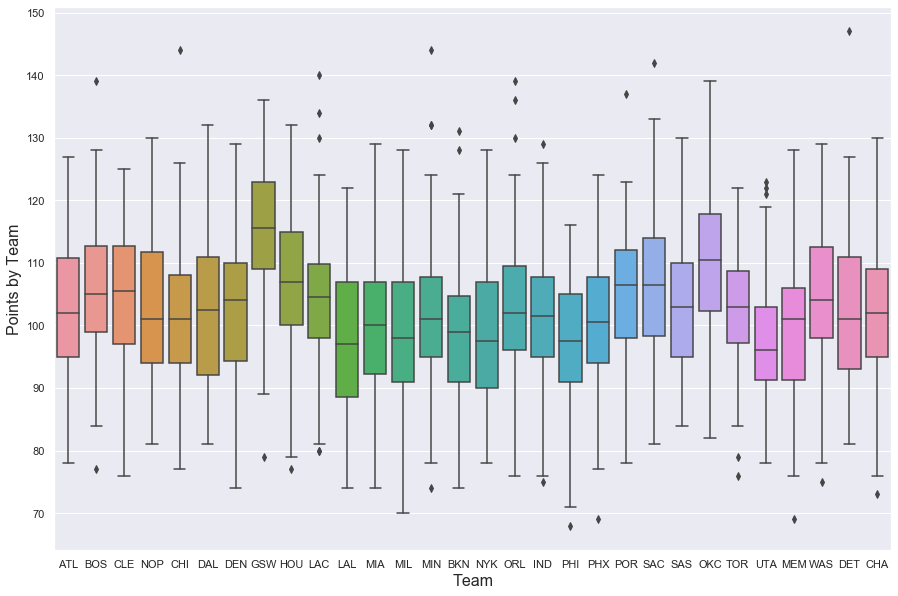

In [36]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="PTS", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Points by Team", fontsize = 16)
plt.show()

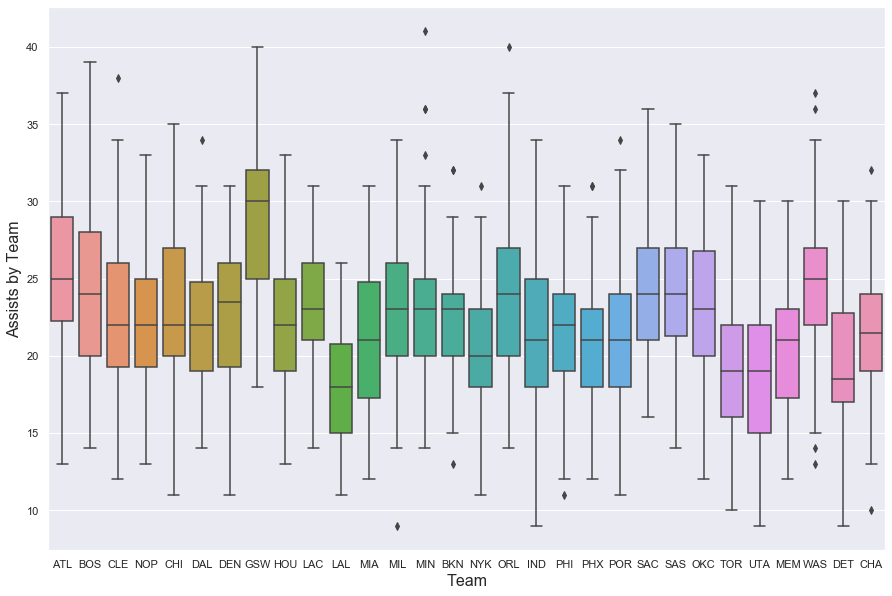

In [37]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="AST", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Assists by Team", fontsize = 16)
plt.show()

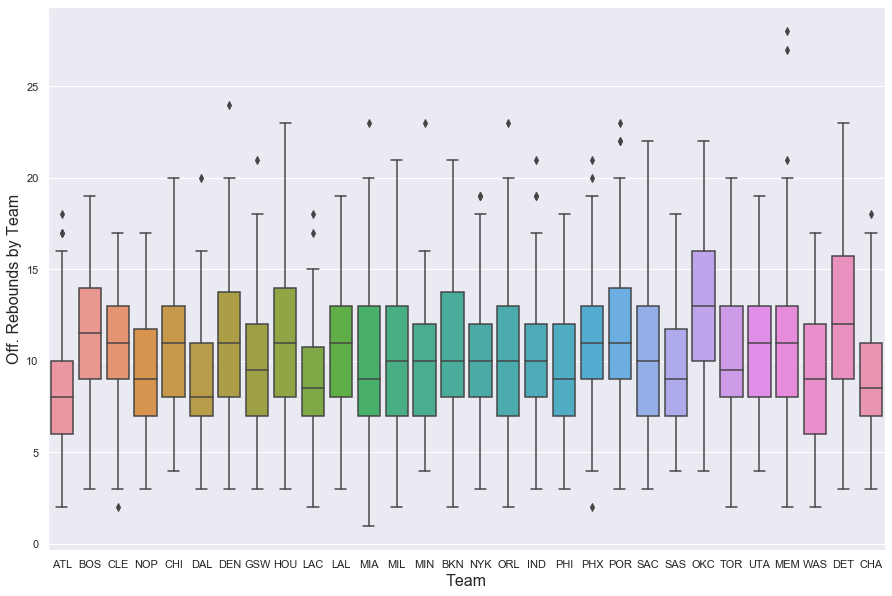

In [39]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="OREB", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Off. Rebounds by Team", fontsize = 16)
plt.show()

### Team Defensive metrics

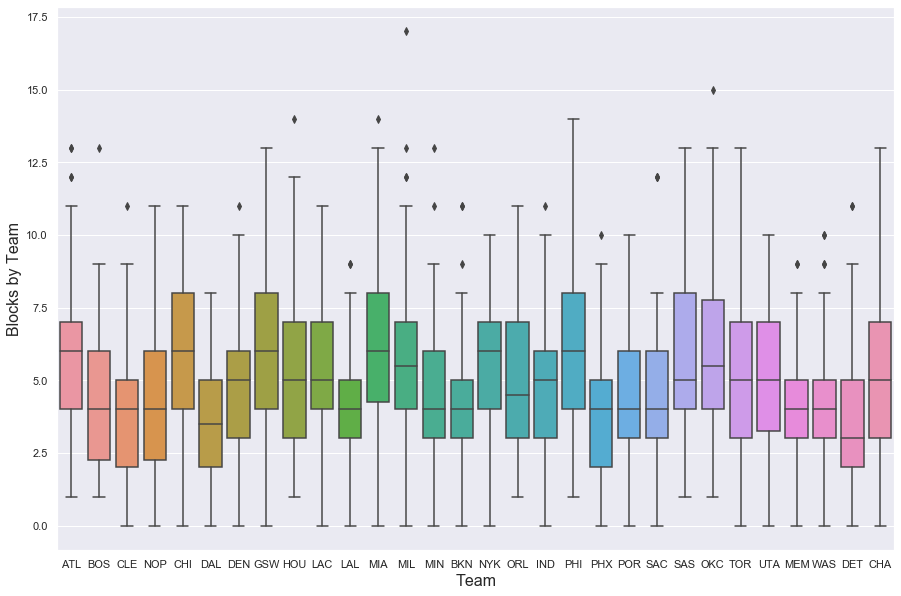

In [38]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="BLK", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Blocks by Team", fontsize = 16)
plt.show()

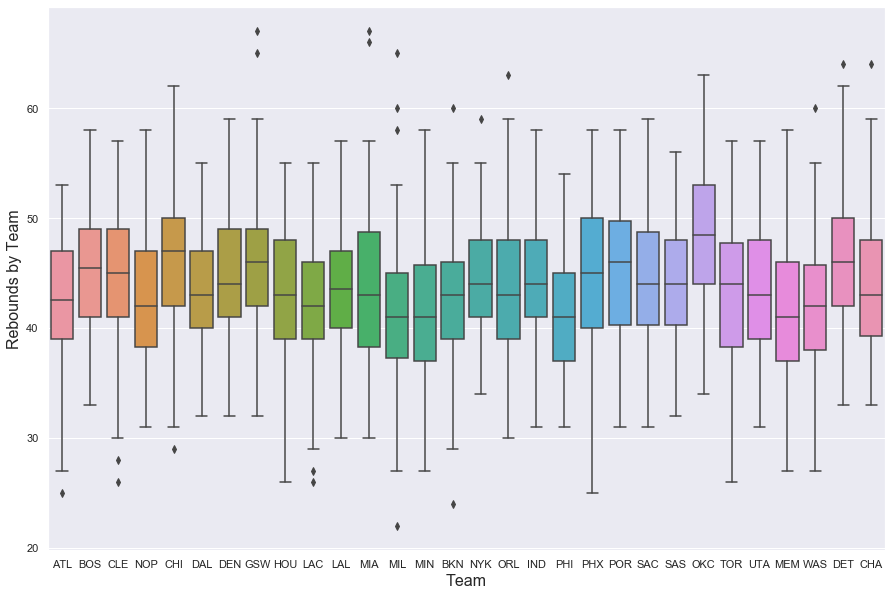

In [40]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data = nba_games_15_16, x="TEAM_ABBREVIATION", y="REB", ax = ax)
plt.xlabel("Team", fontsize = 16)
plt.ylabel("Rebounds by Team", fontsize = 16)
plt.show()

## Looking for simple predictive features

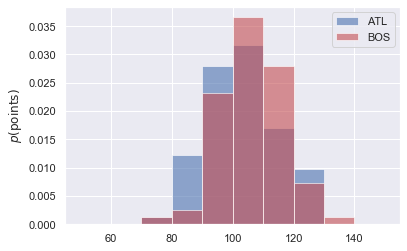

In [66]:
#Probably the silliest thing to do is just add the distributions.
#This assumes that the number of points that each team scores is independent of the other team
#take ATL and BOS as examples
bins = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
mask_ATL = (nba_games_15_16['TEAM_ABBREVIATION'] == 'ATL')
mask_BOS = (nba_games_15_16['TEAM_ABBREVIATION'] == 'BOS')

#atl_pts = 
cts_ATL, _, _ = plt.hist(nba_games_15_16.loc[mask_ATL]['PTS'], density=True, 
                         color='b', alpha=0.6, bins=bins, label='ATL')
cts_BOS, _, _ = plt.hist(nba_games_15_16.loc[mask_BOS]['PTS'], density=True, 
                         color='r', alpha=0.6, bins=bins, label='BOS')
#cts_SUM = cts_ATL + cts_BOS
#plt.bar(bins, cts_SUM)
plt.ylabel(r'$p(\rm points)$')
plt.legend()
plt.show()

### Individual Player Features
What if we model each player as a separate Poisson Process, with their own mean value.
That is, a player has a mean number of scores per minute of playing. And for a future prediction, we the probability of that players points scored is Poisson. 
In general, the amount of points they score will depend on who is assisting them on the court, as well as who is playing defense to block them, etc... 


In [241]:
player_dict = players.get_players()
#display(player_dict)

In [243]:
gamelog_lebron= playergamelog.PlayerGameLog(player_id='2544', season = '2015')
df_lebron = gamelog_lebron.get_data_frames()
df_lebron = df_lebron[0]
df_lebron.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22015,2544,0021501203,"APR 11, 2016",CLE vs. ATL,W,32,13,16,0.813,...,5,6,6,2,1,4,2,34,13,1
1,22015,2544,0021501191,"APR 09, 2016",CLE @ CHI,L,39,13,17,0.765,...,4,7,3,0,1,4,1,33,7,1
2,22015,2544,0021501159,"APR 05, 2016",CLE @ MIL,W,28,7,9,0.778,...,5,5,9,0,1,4,0,17,22,1
3,22015,2544,0021501144,"APR 03, 2016",CLE vs. CHA,W,41,14,22,0.636,...,5,8,12,2,0,5,4,31,10,1
4,22015,2544,0021501131,"APR 01, 2016",CLE @ ATL,W,44,12,26,0.462,...,13,16,9,3,1,3,4,29,6,1


Lebron avg points / game = 34.07


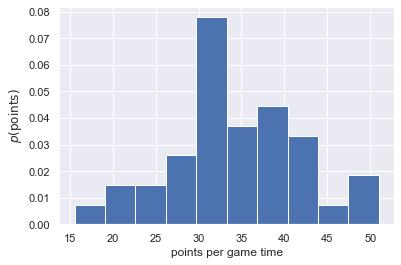

In [143]:
lebron_pts = df_lebron['PTS']
lebron_gametime = df_lebron['MIN'] / 48.
lebron_pts_per_game = lebron_pts / lebron_gametime

mu_lebron = np.mean(lebron_pts_per_game) #estimate of mean
print("Lebron avg points / game = " + str( round( mu_lebron , 2) ) )
plt.hist(lebron_pts_per_game, density=True)
plt.xlabel('points per game time')
plt.ylabel(r'$p(\rm points)$')
plt.show()

In [135]:
from math import factorial
def poisson(k, mu):
    """
    Returns a Poisson distribution value for k with mean mu
    """
    return mu**k * np.exp(-mu) / factorial(k) 

poisson = np.vectorize(poisson)

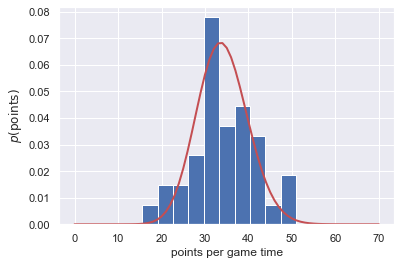

In [144]:
pts_per_game = np.linspace(0, 70, 71)
fit_lebron = poisson(pts_per_game, mu_lebron)
plt.hist(lebron_pts_per_game, density=True)
plt.xlabel('points per game time')
plt.ylabel(r'$p(\rm points)$')
plt.plot(pts_per_game, fit_lebron, color='r', lw=2)
plt.show()

In [140]:
def player_mean_pts_per_game(player_id, season):
    gamelog = playergamelog.PlayerGameLog(player_id=player_id, season = season)
    df = gamelog.get_data_frames()
    df = df[0]
    pts = df['PTS']
    gametime = df['MIN'] / 48.
    pts_per_game = pts / gametime
    mu = np.mean(pts_per_game) #estimate of mean
    return mu

In [152]:
#lets try this for a single game
mask_game = ( nba_games_15_16['GAME_ID'] == '0021501228')
some_game = nba_games_15_16.loc[mask_game]
some_game.columns

Index(['abbreviation', 'SEASON_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS',
       'COMBINED_FINAL_SCORE'],
      dtype='object')

In [166]:
#get all the players who played this game, and for how long
#gamelog = teamandplayersvsplayers.PlayersVsPlayers()
#df = gamelog.get_data_frames()
#df = df[0]
#df.columnsm

AttributeError: module 'nba_api.stats.endpoints.teamandplayersvsplayers' has no attribute 'PlayersVsPlayers'

## Lets try each team as a Poisson process (simpler)

In [213]:
team_ids = nba_games_15_16['TEAM_ID'].unique()
print(team_ids)

[1610612737 1610612738 1610612739 1610612740 1610612741 1610612742
 1610612743 1610612744 1610612745 1610612746 1610612747 1610612748
 1610612749 1610612750 1610612751 1610612752 1610612753 1610612754
 1610612755 1610612756 1610612757 1610612758 1610612759 1610612760
 1610612761 1610612762 1610612763 1610612764 1610612765 1610612766]


In [192]:
def team_mean_pts_per_game(team_id):
    mask = (nba_games_15_16['TEAM_ID'] == team_id)
    team_df = nba_games_15_16.loc[mask]
    mu = team_df['PTS'].mean()
    return mu

In [194]:
mu_ATL = team_mean_pts_per_game(team_id=1610612737)
print("ATL mean points per game : " + str(round(mu_ATL, 2)))

ATL mean points per game : 102.84


### We can model points by each team individually as Poisson
$\rm Pois(\mu = \mu_1)$ for team 1, $\rm Pois(\mu = \mu_2)$ for team 2


Then, the total number of points is distributed as $\rm Pois(\mu = \mu_1 + \mu_2)$

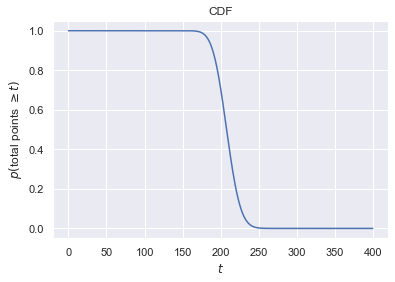

In [215]:
#let's try some specific games
team_1 = 1610612737
team_2 = 1610612738

mu_1 = team_mean_pts_per_game(team_id=team_1)
mu_2 = team_mean_pts_per_game(team_id=team_2)
mu_t = mu_1 + mu_2

tot_pts_possible = np.linspace(0, 400, 401)
prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t
plt.plot(tot_pts_possible, prob_gt_t)
plt.xlabel(r'$t$')
plt.ylabel(r'$p($total points $ \geq t)$')
plt.title('CDF')
plt.show()

In [275]:
#try for a pair of teams
team_1 = 1610612737
team_2 = 1610612738

team_1_abb = teams_df[ teams_df['TEAM_ID'] == team_1 ]['abbreviation'].values[0]
team_2_abb = teams_df[ teams_df['TEAM_ID'] == team_2 ]['abbreviation'].values[0]

print("team_1 : " + team_1_abb)
print("team_2 : " + team_2_abb)

mu_1 = team_mean_pts_per_game(team_id=team_1)

print("Mean points per game team_1 : " + str(mu_1))
    
mask_team1 = nba_games_15_16['TEAM_ABBREVIATION'] == team_1_abb
games_team1 = nba_games_15_16.loc[mask_team1]
       
mu_2 = team_mean_pts_per_game(team_id=team_2)
print("Mean points per game team_2 : " + str(mu_2))

mu_t = mu_1 + mu_2
prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t

match_games = games_team1[games_team1['MATCHUP'].str.contains(team_2_abb)]
display(match_games)

team_1 : ATL
team_2 : BOS
Mean points per game team_1 : 102.84146341463415
Mean points per game team_2 : 105.71951219512195


,abbreviation,city,full_name,TEAM_ID,nickname,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
379,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,5,39,44,31,10,10,17,22,11.0,225
431,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,9,33,42,23,11,4,12,28,8.0,210
443,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,6,37,43,33,8,7,20,25,24.0,218
448,ATL,Atlanta,Atlanta Hawks,1610612737,Hawks,Atlanta,1949,22015,ATL,Atlanta Hawks,...,5,30,35,26,3,2,16,14,-13.0,199


In [272]:
#now lets try looping over all pairs of teams
tot_pts_possible = np.linspace(0, 400, 401)

for team_1 in team_ids:
    team_1_abb = teams_df[ teams_df['TEAM_ID'] == team_1 ]['abbreviation'].values[0]

    mu_1 = team_mean_pts_per_game(team_id=team_1)
    
    mask_team1 = nba_games_15_16['TEAM_ABBREVIATION'] == team_1_abb
    games_team1 = nba_games_15_16.loc[mask_team1]
    
    for team_2 in team_ids:
        team_2_abb = teams_df[ teams_df['TEAM_ID'] == team_2 ]['abbreviation'].values[0]
        
        mu_2 = team_mean_pts_per_game(team_id=team_2)
        mu_t = mu_1 + mu_2
        prob_lt_t = poisson.cdf(tot_pts_possible, mu_t)
        prob_gt_t = np.ones_like(prob_lt_t) - prob_lt_t
        
        match_games = games_team1[games_team1['MATCHUP'].str.contains(team_2_abb)]

## Trying a more complicated model than Univariate Poisson
Poisson for each team assumes that each team scores are independent of their opponent, which is a bit naive. When a team plays an opponent with strong defense, they will score less...

references : 

https://pdfs.semanticscholar.org/87b1/f65f8dc33d5f6ec33ce04df49e9b159038d3.pdf

https://gawhitaker.github.io/project.pdf

